In [5]:
!pip install squarify
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 146.1 MB/s eta 0:00:00


In [59]:
import os
import sys
import math
import ast
import datetime
import glob
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pingouin
import squarify
from tqdm.notebook import tqdm
import seaborn as sns

In [7]:
object_data = pd.read_csv('./2024_Mar_ob_count.csv')

In [12]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

super_categories = {'people' : ['person','vendor'],
                    'small_vehicles' : ['car', 'taxi','truck'],
                    'two_wheelers' : ['bicycle', 'motorcycle'],
                    'large_vehicles' : ['trotro', 'van', 'lorry','bus'],
                    'refuse' : ['trash', 'debris'],
                    'market': ['umbrella','stall','bowl','food']}

In [10]:
object_data['datetime'] = pd.to_datetime(object_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [42]:
# Filter rows where the lowercase first letter of 'site_id' is not 's'
fixed_object_data = object_data[~object_data['site_id'].str.lower().str.startswith('s')]

# Display the first few rows of the new dataframe to verify
fixed_object_data.head()


,directory,image_name,datetime,date,site_id,camera_name,animal_counts,bicycle_counts,bowl_counts,bus_counts,...,person_counts,stall_counts,stove_counts,taxi_counts,trash_counts,trotro_counts,truck_counts,umbrella_counts,van_counts,vendor_counts
0,AD_12_04_2019_C14,MFDC0294.JPG,2019-04-12 10:25:49,2019-04-12,AD,C14,0,0,0,0,...,32,0,0,6,0,3,0,0,1,0
1,AD_12_04_2019_C14,MFDC0295.JPG,2019-04-12 10:30:49,2019-04-12,AD,C14,0,1,0,0,...,29,1,0,3,0,1,1,0,1,0
2,AD_12_04_2019_C14,MFDC0296.JPG,2019-04-12 10:35:49,2019-04-12,AD,C14,0,0,0,0,...,28,1,0,2,0,2,2,0,1,0
3,AD_12_04_2019_C14,MFDC0297.JPG,2019-04-12 10:40:49,2019-04-12,AD,C14,0,0,0,0,...,21,1,0,2,0,1,1,1,1,0
4,AD_12_04_2019_C14,MFDC0298.JPG,2019-04-12 10:45:49,2019-04-12,AD,C14,0,0,0,0,...,30,1,0,1,0,2,4,0,1,0


In [44]:
# Group by 'site_id' and aggregate unique 'camera_name' into lists
site_cams = fixed_object_data.groupby('site_id')['camera_name'].unique().apply(list).to_dict()

site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1W': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'NM': ['Nima', 'High-density\nresidential', 'red'],
             'TF': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

print(site_cams)

{'AD': ['C14', 'C17', 'C4', 'C12', 'S21', 'C5', 'C22'], 'ASH': ['C6', 'C13', 'C22', 'C11'], 'EL': ['C28', 'C18', 'C32', 'C01', 'C8', 'C12', 'C10', 'C41', 'S85', '2021', 'C15', 'C36', 'C11', 'C20', 'S75'], 'JT': ['C31', 'C11', 'C21', 'C9', 'C28', 'C44', 'S44', 'C14'], 'LA': ['C35', 'C16', 'C25', '2022', 'C01', 'C28', 'C8', 'C14', 'C18'], 'N1W': ['C36', 'C15', 'C34', 'C8', 'C33', '36', 'S15', 'C41', 'C12', 'C18', 'C19'], 'NM': ['C26', 'C02', 'C2', 'C13', 'S17', 'C27', 'C33', 'C32', 'C40', '2021', 'C44', 'C21'], 'TF': ['C21', 'C22', 'C32', 'C11', 'C5', 'C28', 'C26', 'C42', 'C23', '26', 'C14', 'S75'], 'TMW': ['2019', 'C30', 'C19', 'C1', 'C14', 'C20', 'C12', 'C11'], 'UGH': ['C25', 'C5', 'C12', 'C33', 'C23', 'C42', 'C', 'C30', 'C36']}


In [45]:
obj_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash', 'vendor', 'loudspeaker', 'stove', 'bus']

print(fixed_object_data[[cat+'_counts' for cat in obj_categories]].sum())

person_counts         34350600
umbrella_counts       12336975
stall_counts             82419
food_counts             302845
bowl_counts            1445213
car_counts            14726597
taxi_counts            2680311
truck_counts           1362327
bicycle_counts          266033
motorcycle_counts       999406
animal_counts            37420
trotro_counts         10110304
van_counts              787301
lorry_counts            345895
debris_counts           549955
trash_counts           1943041
vendor_counts           715103
loudspeaker_counts       58902
stove_counts             16929
bus_counts              157736
dtype: int64


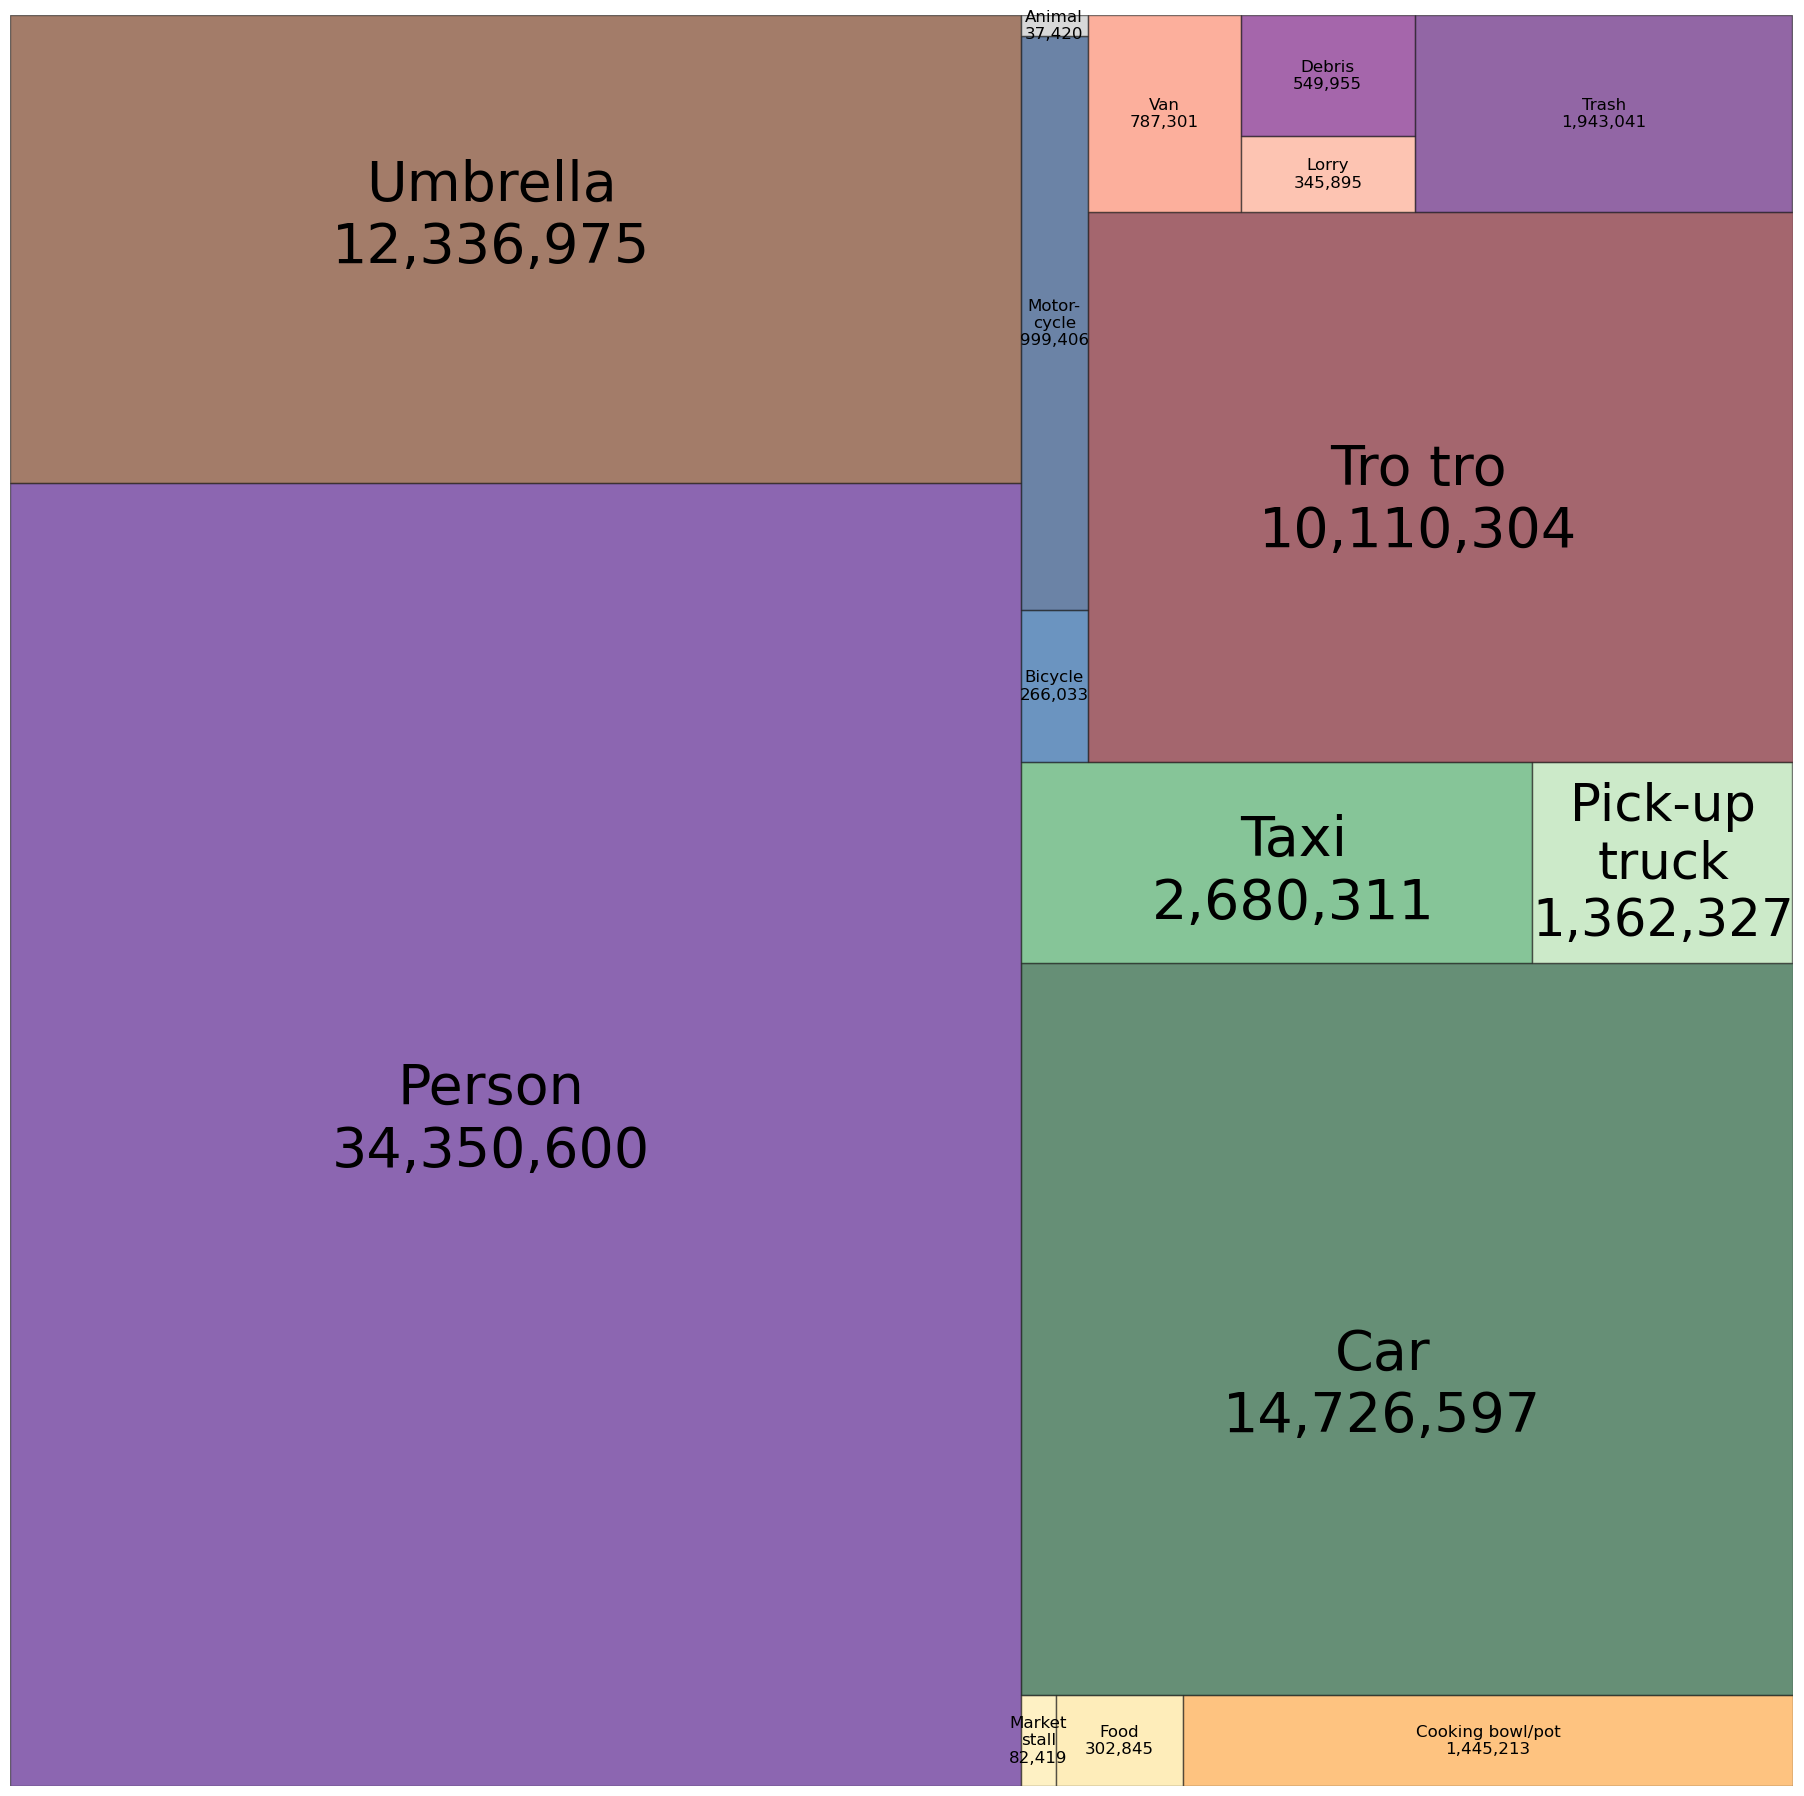

In [46]:
# Treemap generation

import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(23,23),linewidth=0)

tree_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash']

total_counts = fixed_object_data[[cat+'_counts' for cat in tree_categories]].sum()#.sort_values(ascending=False)

sizes=[float(size/10000) for size in total_counts.values]

label=[obj[0].replace("trotro","tro tro")
             .replace("truck","pick-up\ntruck")
             .replace("stall","market\nstall")
             .replace("bowl","cooking bowl/pot")
             .replace("_counts","\n"+str(f"{int(obj[1]):,}")).capitalize().replace("rcycle","r-\ncycle") for obj in zip(total_counts.index,total_counts.values)]
label_mod=label.copy()

for i in [0,1,5,6,7,11]:
    label_mod[i]= ""

cmap_1 = plt.cm.Purples
cmap_2 = plt.cm.YlOrBr
cmap_3 = plt.cm.Greens
cmap_4 = plt.cm.Blues
cmap_5 = plt.cm.Greys
cmap_6 = plt.cm.Reds
cmap_7 = plt.cm.RdPu

norm_1 = colors.Normalize(vmin=0, vmax=4000000)
norm_2 = colors.Normalize(vmin=-1000000, vmax=4000000)
norm_3 = colors.Normalize(vmin=0, vmax=4000000)
norm_4 = colors.Normalize(vmin=0, vmax=300000)
norm_5 = colors.Normalize(vmin=0, vmax=100000)
norm_6 = colors.Normalize(vmin=-1000000, vmax=3000000)
norm_7 = colors.Normalize(vmin=0, vmax=600000)

colors = [cmap_1(norm_1(value)) for value in total_counts.values[:1]]+\
         [cmap_2(norm_2(value)) for value in total_counts.values[1:5]]+\
         [cmap_3(norm_3(value)) for value in total_counts.values[5:8]]+\
         [cmap_4(norm_4(value)) for value in total_counts.values[8:10]]+\
         [cmap_5(norm_5(value)) for value in total_counts.values[10:11]]+\
         [cmap_6(norm_6(value)) for value in total_counts.values[11:14]]+\
         [cmap_7(norm_7(value)) for value in total_counts.values[14:]]

#print(label)
squarify.plot(sizes=sizes, label=label_mod, color=colors, alpha=0.6,text_kwargs={'fontsize':12, 'color':'black', 'fontweight':"medium"},bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
fontsize = 40
plt.text(27,35, label[0], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(27, 86, label[1], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(77, 20, label[5], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(72, 49, label[6], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(92.75, 48, label[7], color='black',fontsize=fontsize-3,alpha=1,horizontalalignment='center')
plt.text(79, 70, label[11], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.axis('off')
plt.show()
fig.savefig('./results/treemap.pdf',format='pdf',edgecolor="#000000", bbox_inches='tight', pad_inches=0.1)

Plotting Progress:   0%|          | 0/10 [00:00<?, ?it/s]

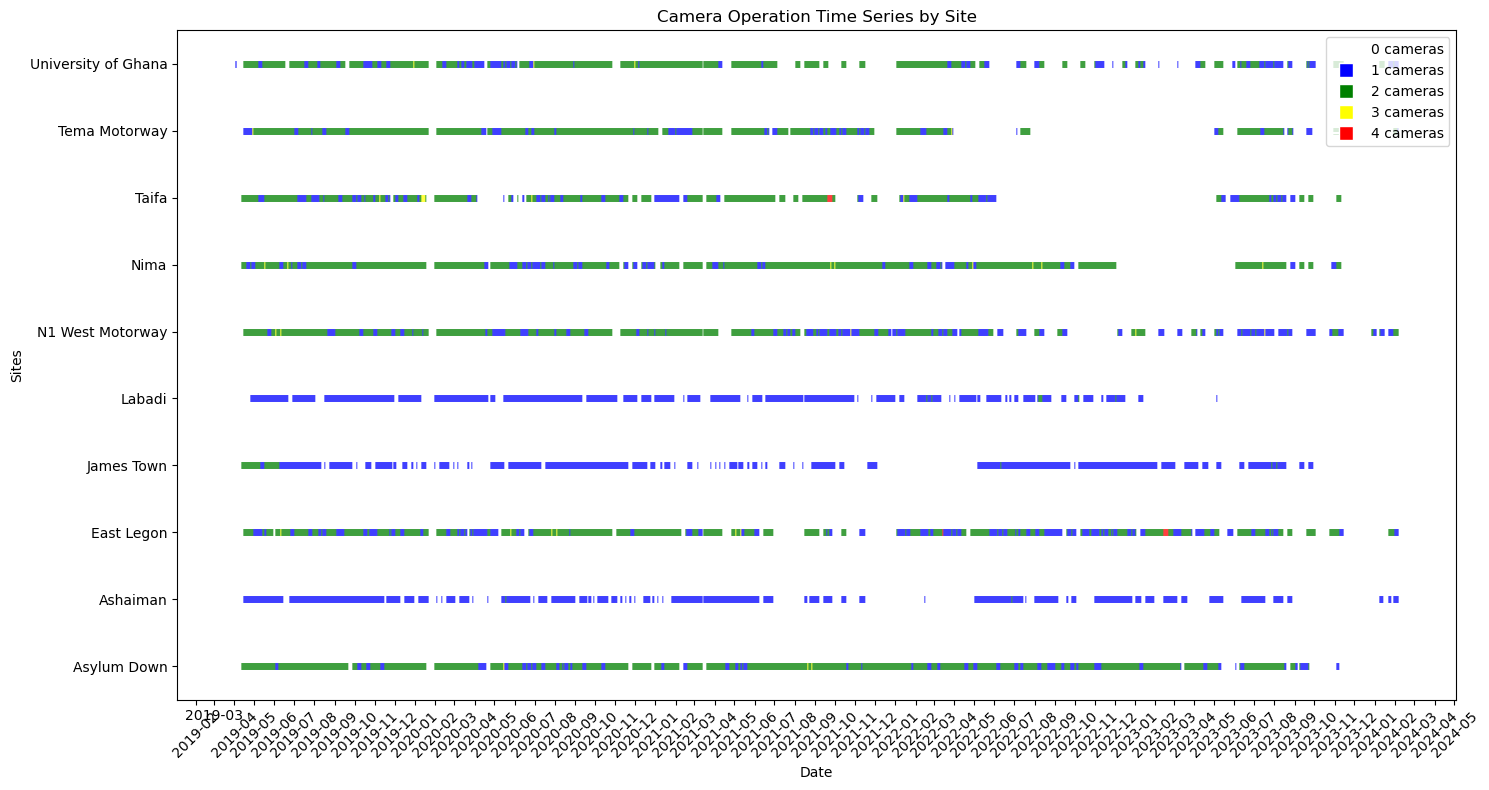

In [57]:
# Count unique cameras per site per day
camera_counts_per_day = fixed_object_data.groupby(['site_id', fixed_object_data['datetime'].dt.date])['camera_name'].nunique().reset_index(name='camera_counts')

# Pivot table to have dates as index and sites as columns, filling missing values with 0
pivot_camera_counts = camera_counts_per_day.pivot(index='datetime', columns='site_id', values='camera_counts').fillna(0)

# Replace site_id with full names from site_type
pivot_camera_counts.columns = pivot_camera_counts.columns.map(lambda x: site_type[x][0] if x in site_type else x)

colors = {0: 'white', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'red'}

import matplotlib.dates as mdates
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
from matplotlib.collections import BrokenBarHCollection

fig, ax = plt.subplots(figsize=(15, 8))

# Replace DayLocator with MonthLocator
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.yticks(range(len(pivot_camera_counts.columns)), pivot_camera_counts.columns)
plt.xticks(rotation=45)

# Reduce linewidths to avoid bars being too thick
line_width = 5

for i, site in tqdm(enumerate(pivot_camera_counts.columns), total=len(pivot_camera_counts.columns), desc="Plotting Progress"):
    for date, count in pivot_camera_counts[site].items():
        date_num = date2num(date)
        ax.hlines(i, date_num - 0.5, date_num + 0.5, colors=colors.get(count, 'black'), linewidths=line_width)

# Set the ylim to add some space at the top and bottom
ax.set_ylim(-0.5, len(pivot_camera_counts.columns) - 0.5)

# Turn off the grid to avoid visual clutter
ax.grid(False)

ax.set_xlabel('Date')
ax.set_ylabel('Sites')
ax.set_title('Camera Operation Time Series by Site')

# Create legend elements based on 'colors' dictionary
legend_elements = [Line2D([0], [0], marker='s', color='w', label='{} cameras'.format(i), markerfacecolor=color, markersize=10) for i, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('./camera_timeline_monthly_ticks.png')

In [58]:
# Step 1: Round the 'datetime' to the nearest hour
fixed_object_data['datetime_hour'] = fixed_object_data['datetime'].dt.round('H')

# Step 2: Sum the counts within each hour for each camera at each site
hourly_counts = fixed_object_data.groupby(['site_id', 'camera_name', 'datetime_hour'])[count_cols].sum().reset_index()

# Step 3: Group by the rounded 'datetime', 'date', and 'site_id', then calculate the mean for each object category
hourly_averages = hourly_counts.groupby(['site_id', 'datetime_hour'])[count_cols].mean().reset_index()

# Add the date column from the rounded 'datetime_hour'
hourly_averages['date'] = hourly_averages['datetime_hour'].dt.date

# Reorder the columns to match the requested format
final_columns = ['datetime_hour', 'date', 'site_id'] + count_cols
hourly_averages = hourly_averages[final_columns]

# Rename 'datetime_hour' to 'datetime' to match the final requested column name
hourly_averages.rename(columns={'datetime_hour': 'datetime'}, inplace=True)

# Display the first few rows of the new dataframe to verify
hourly_averages.head()


/tmp/ipykernel_201/674375853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_object_data['datetime_hour'] = fixed_object_data['datetime'].dt.round('H')


,datetime,date,site_id,car_counts,person_counts,trotro_counts,stall_counts,truck_counts,stove_counts,motorcycle_counts,...,bus_counts,trash_counts,taxi_counts,van_counts,debris_counts,loudspeaker_counts,bowl_counts,food_counts,animal_counts,bicycle_counts
0,2019-04-12 10:00:00,2019-04-12,AD,9.0,32.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-12 11:00:00,2019-04-12,AD,228.0,219.0,30.5,5.5,16.5,0.0,16.0,...,0.5,0.0,45.5,4.0,0.0,0.0,0.5,0.0,0.0,0.5
2,2019-04-12 12:00:00,2019-04-12,AD,314.0,230.5,49.5,5.0,26.5,0.0,15.0,...,2.0,0.5,59.5,4.0,0.5,0.0,0.5,0.0,0.0,2.5
3,2019-04-12 13:00:00,2019-04-12,AD,371.5,192.5,43.5,4.0,29.5,0.0,12.5,...,2.0,1.5,81.0,8.5,0.5,0.0,1.0,0.0,0.0,0.5
4,2019-04-12 14:00:00,2019-04-12,AD,351.5,205.0,60.5,2.0,18.5,0.0,20.0,...,1.0,0.0,62.0,3.5,0.0,0.0,0.5,0.0,0.0,1.0


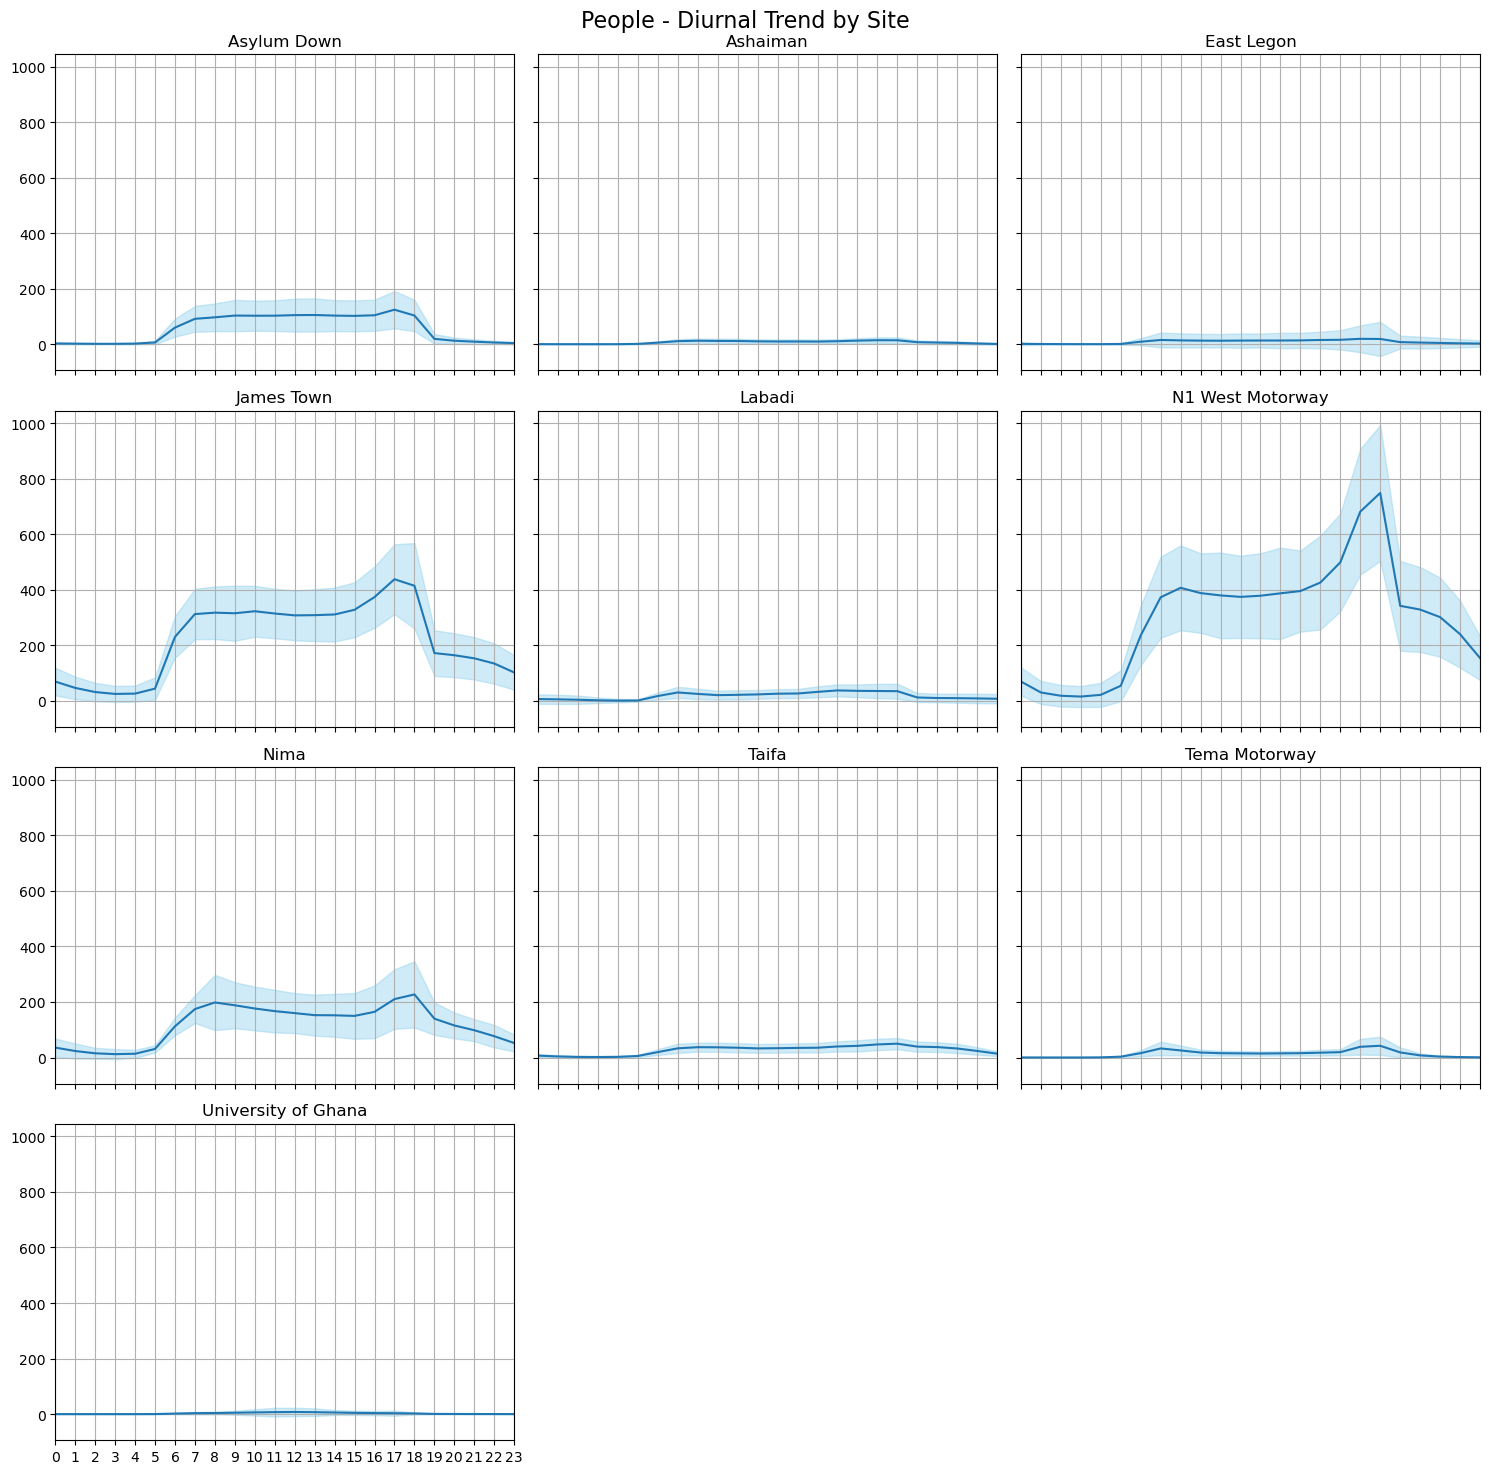

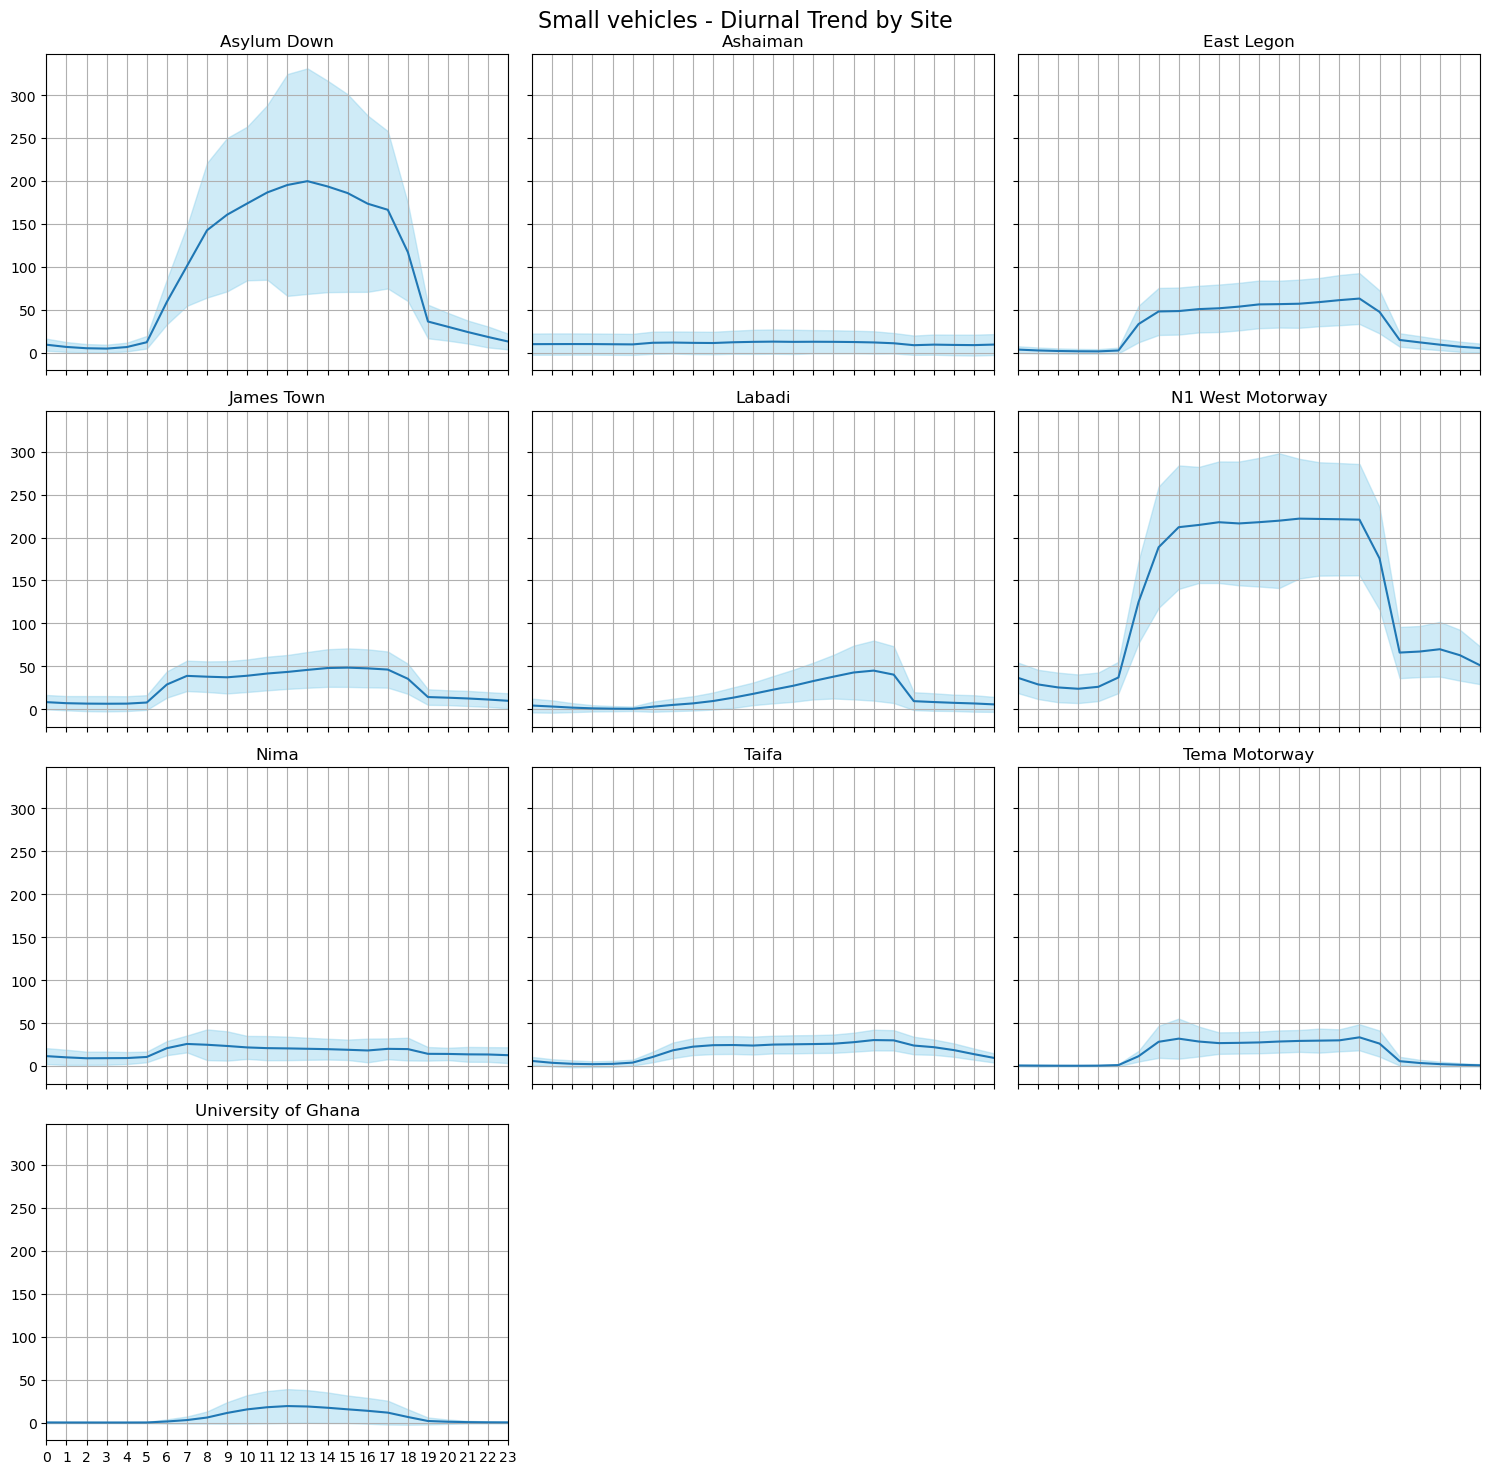

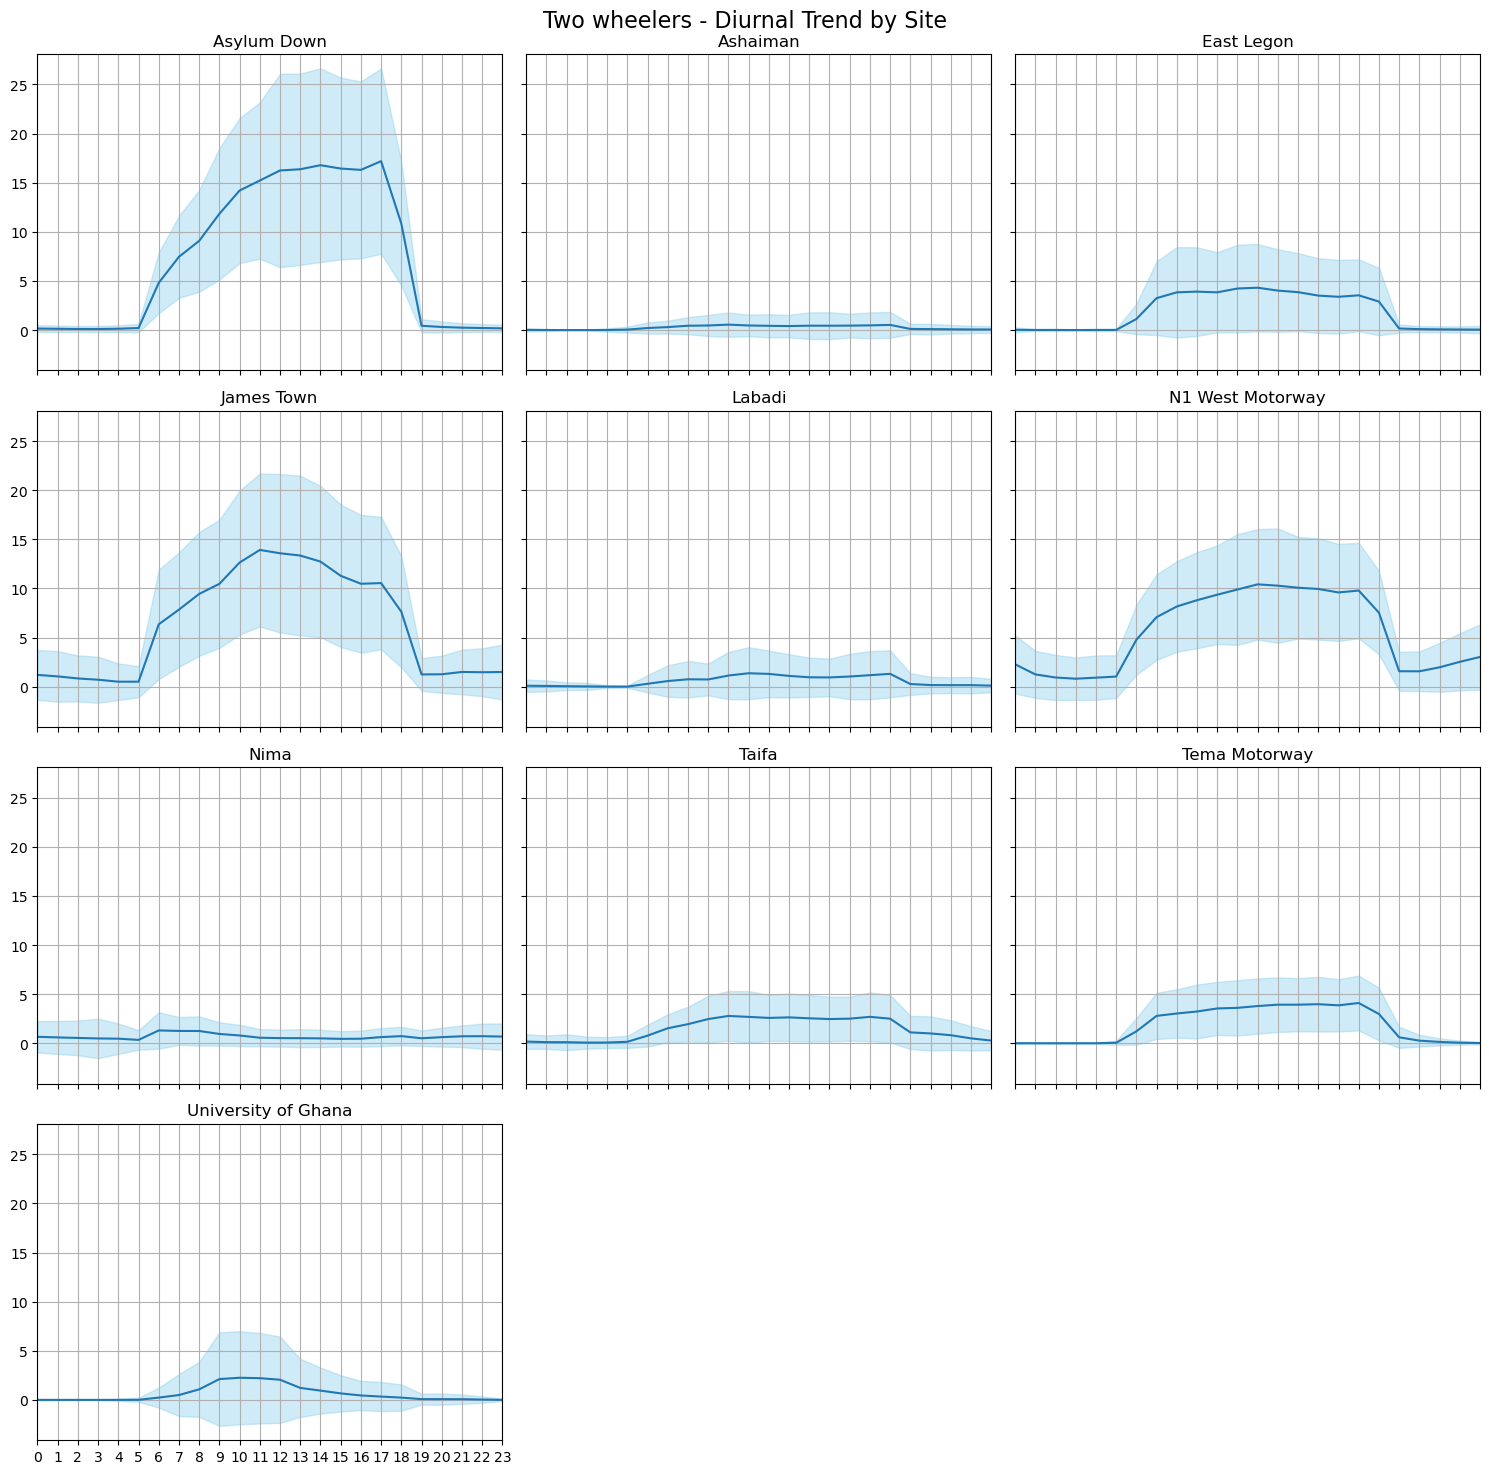

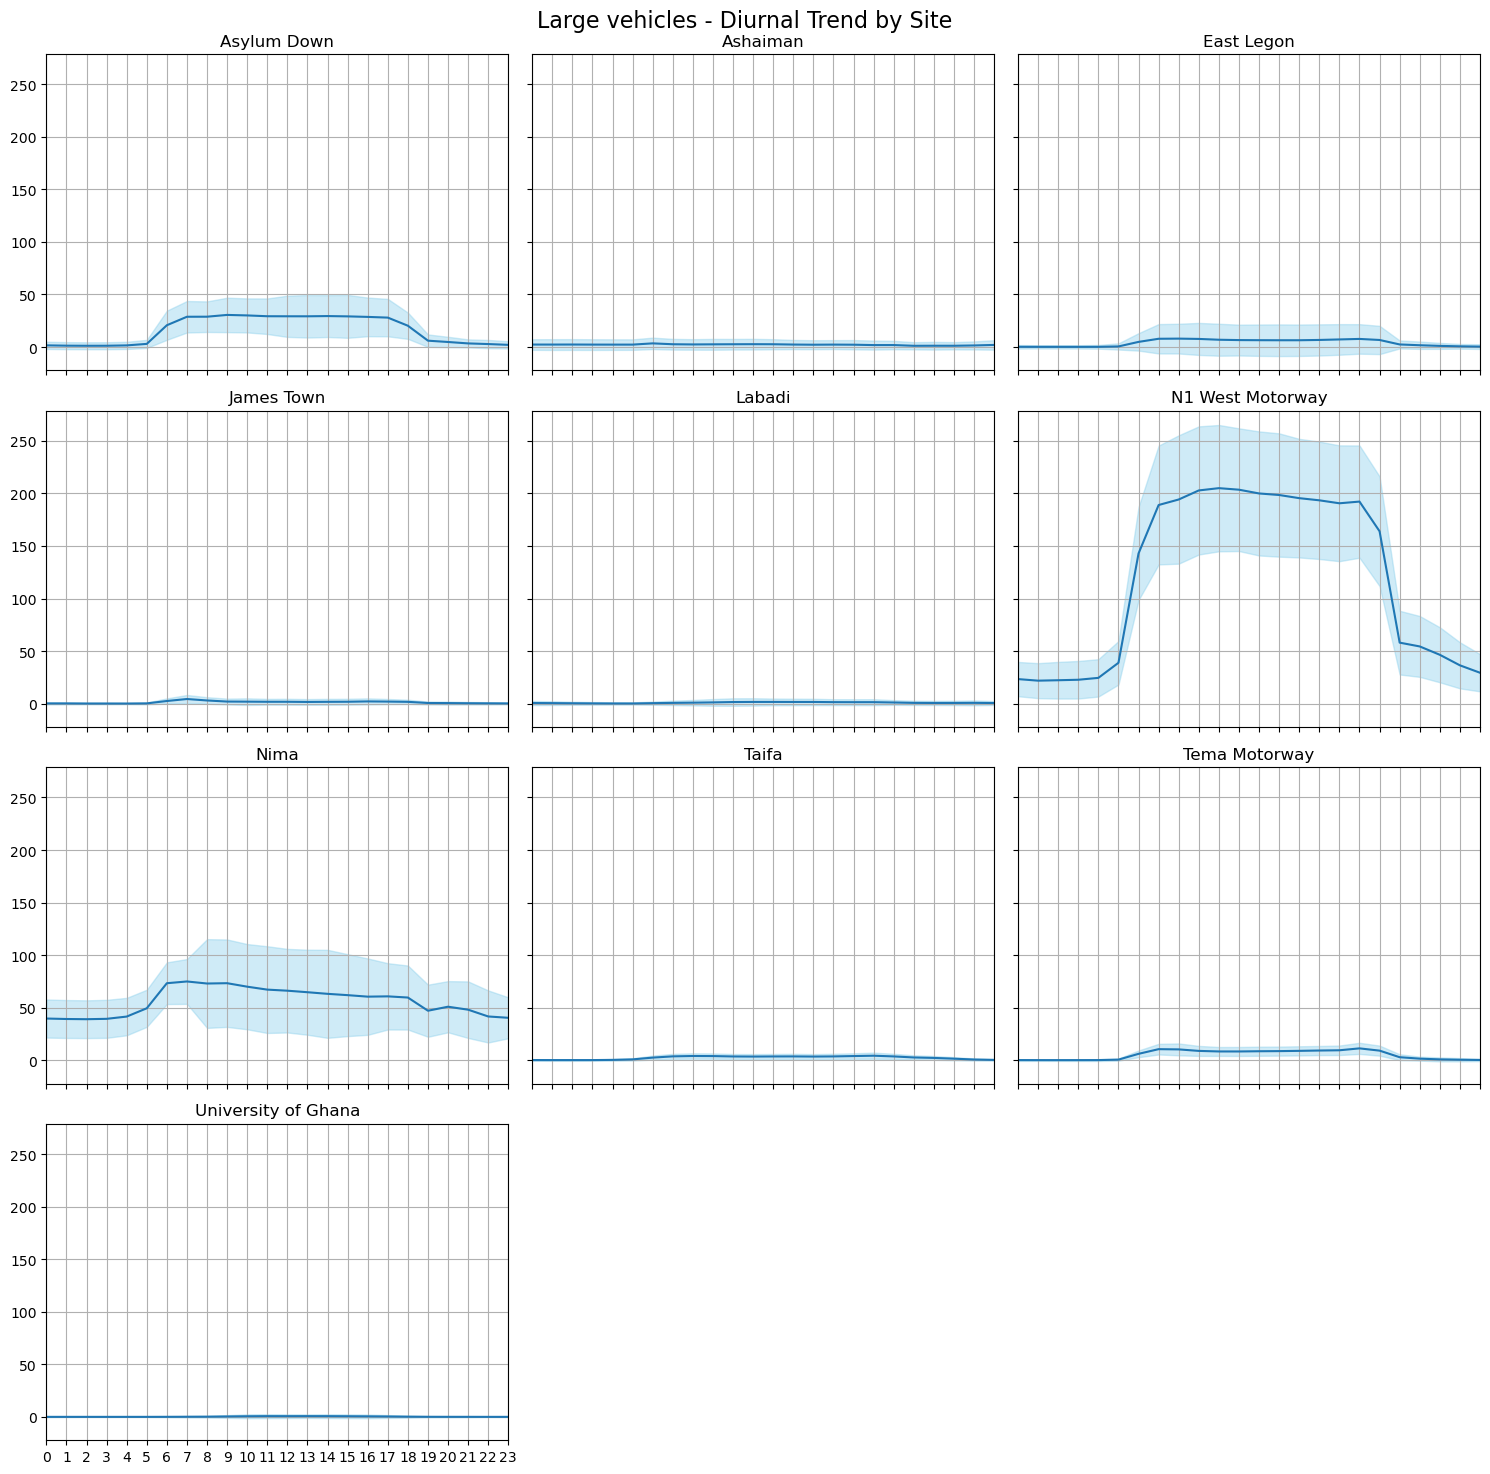

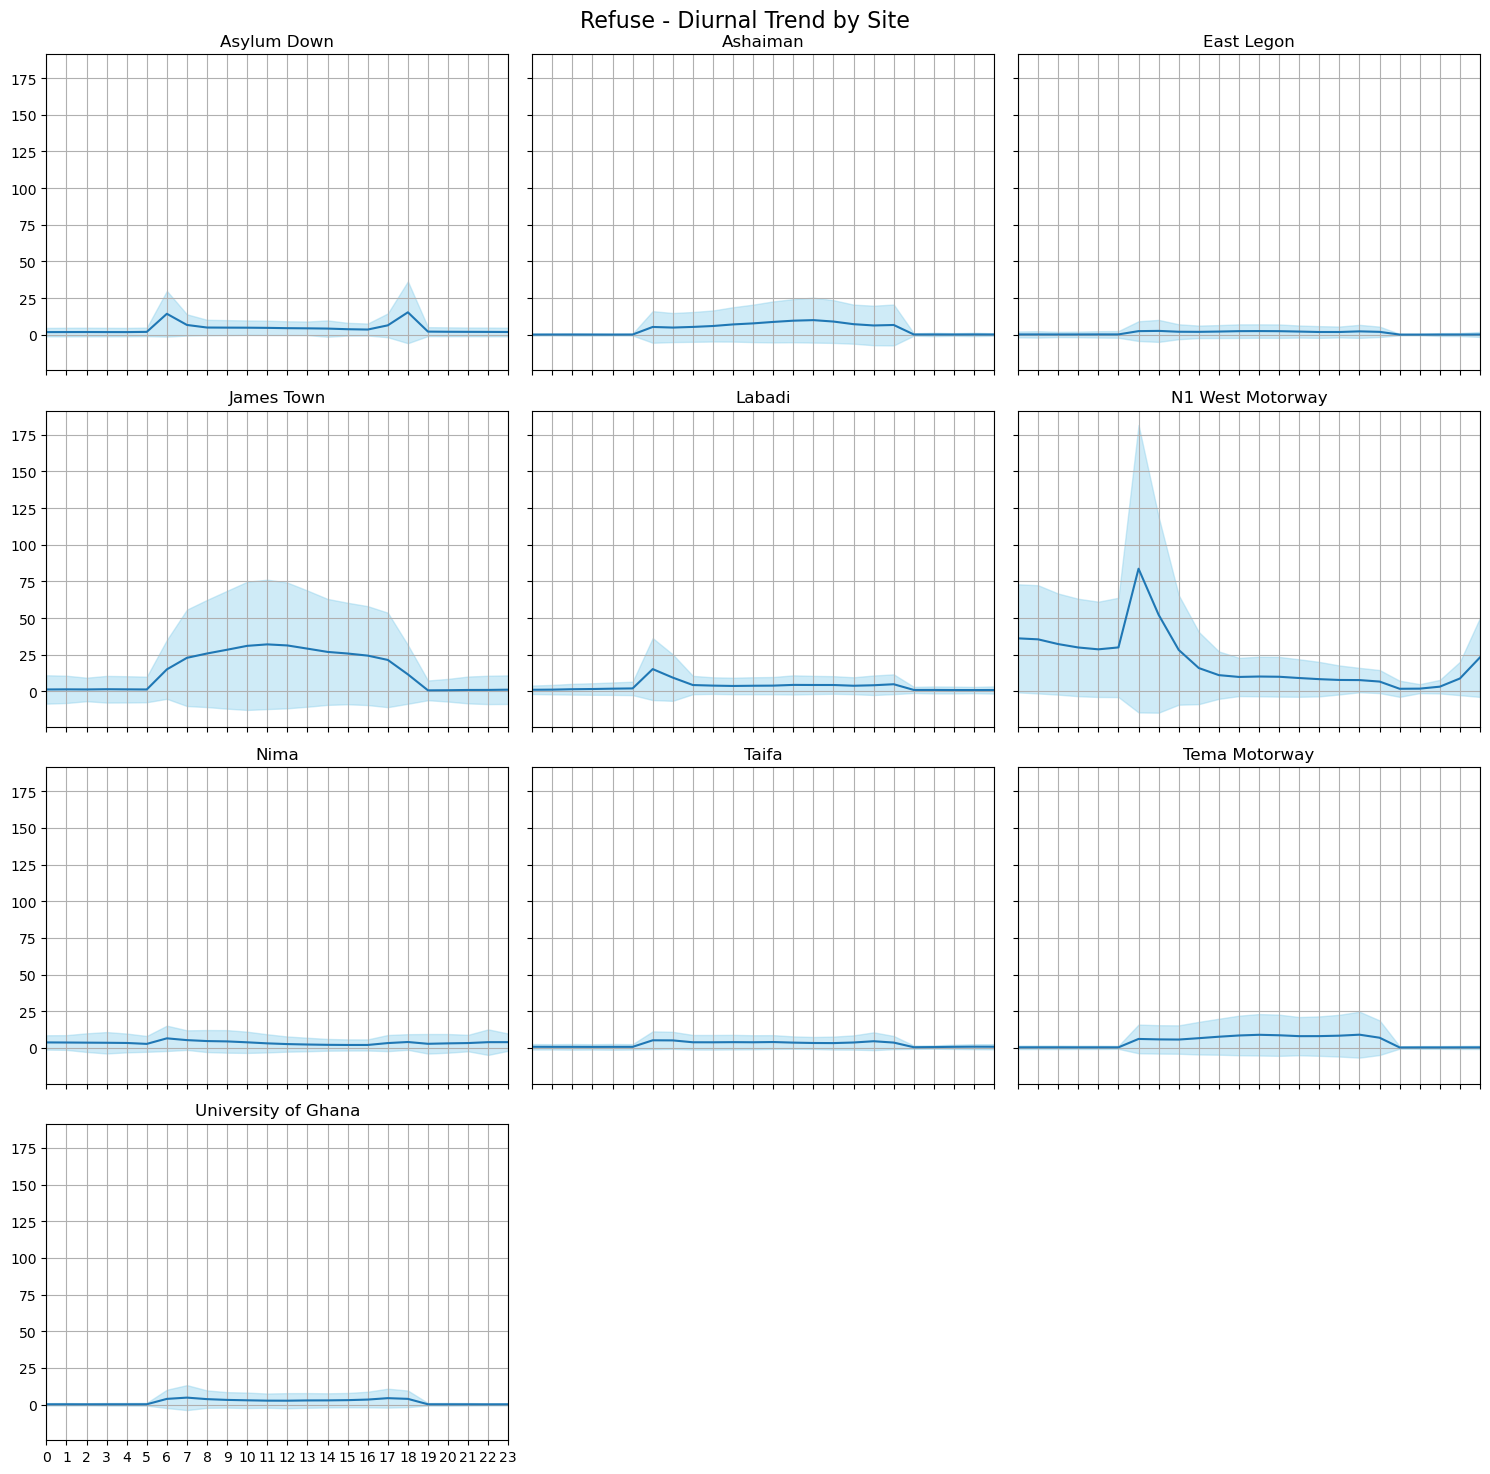

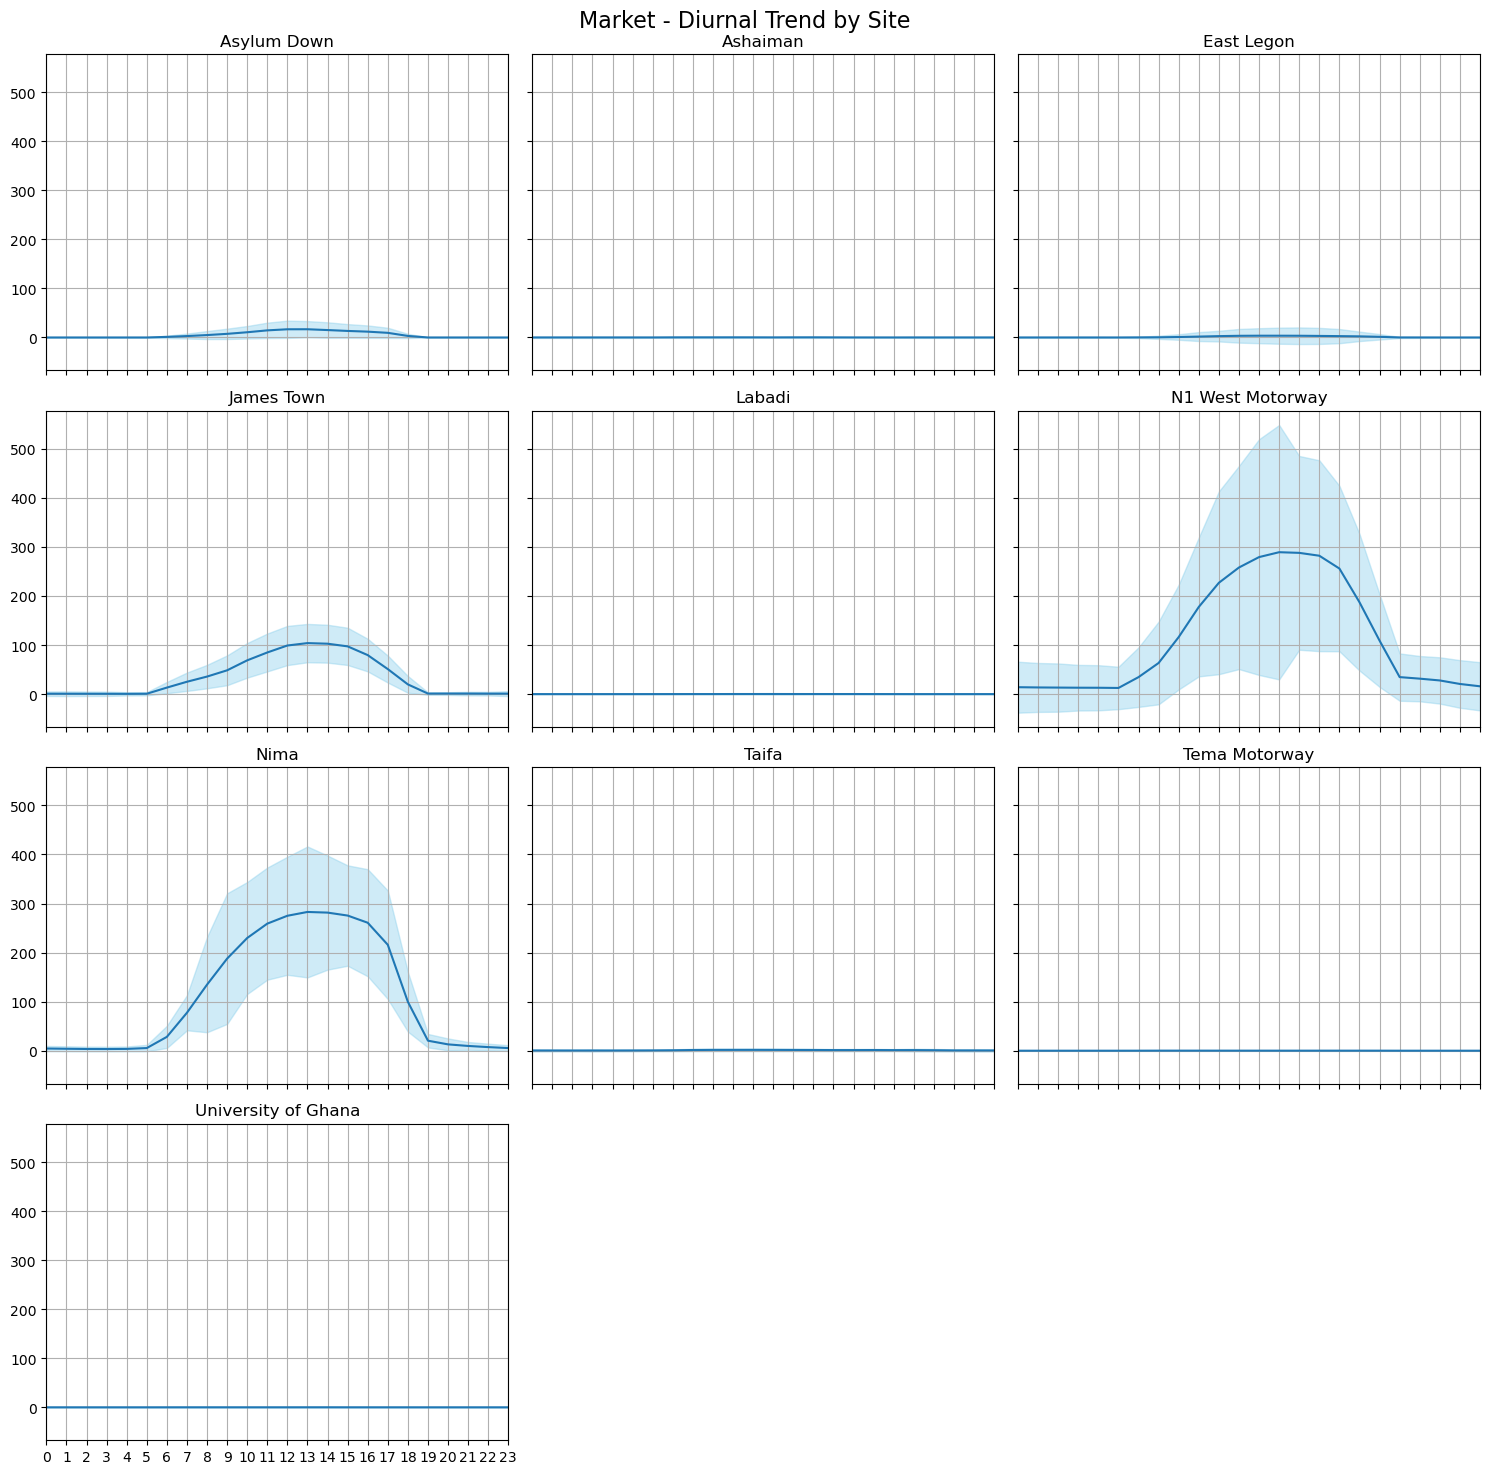

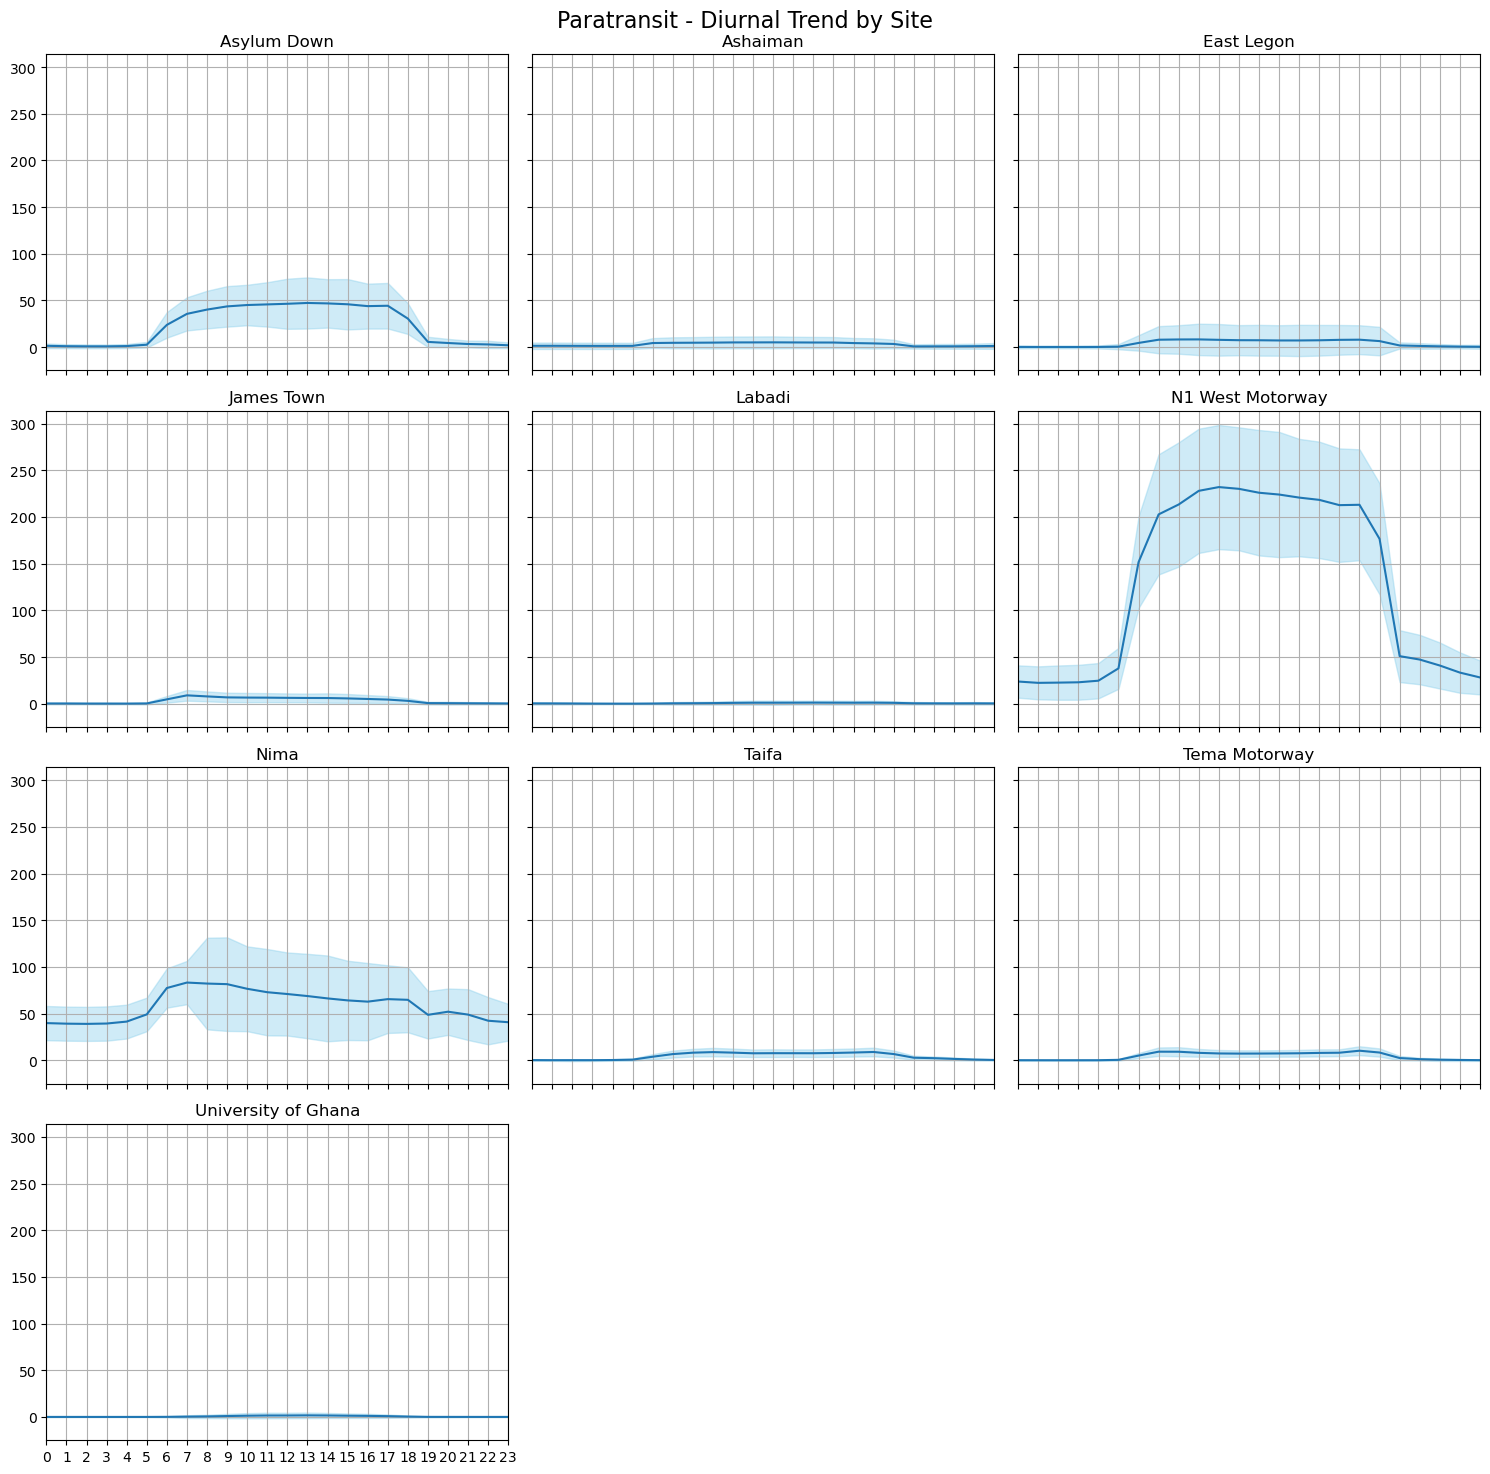

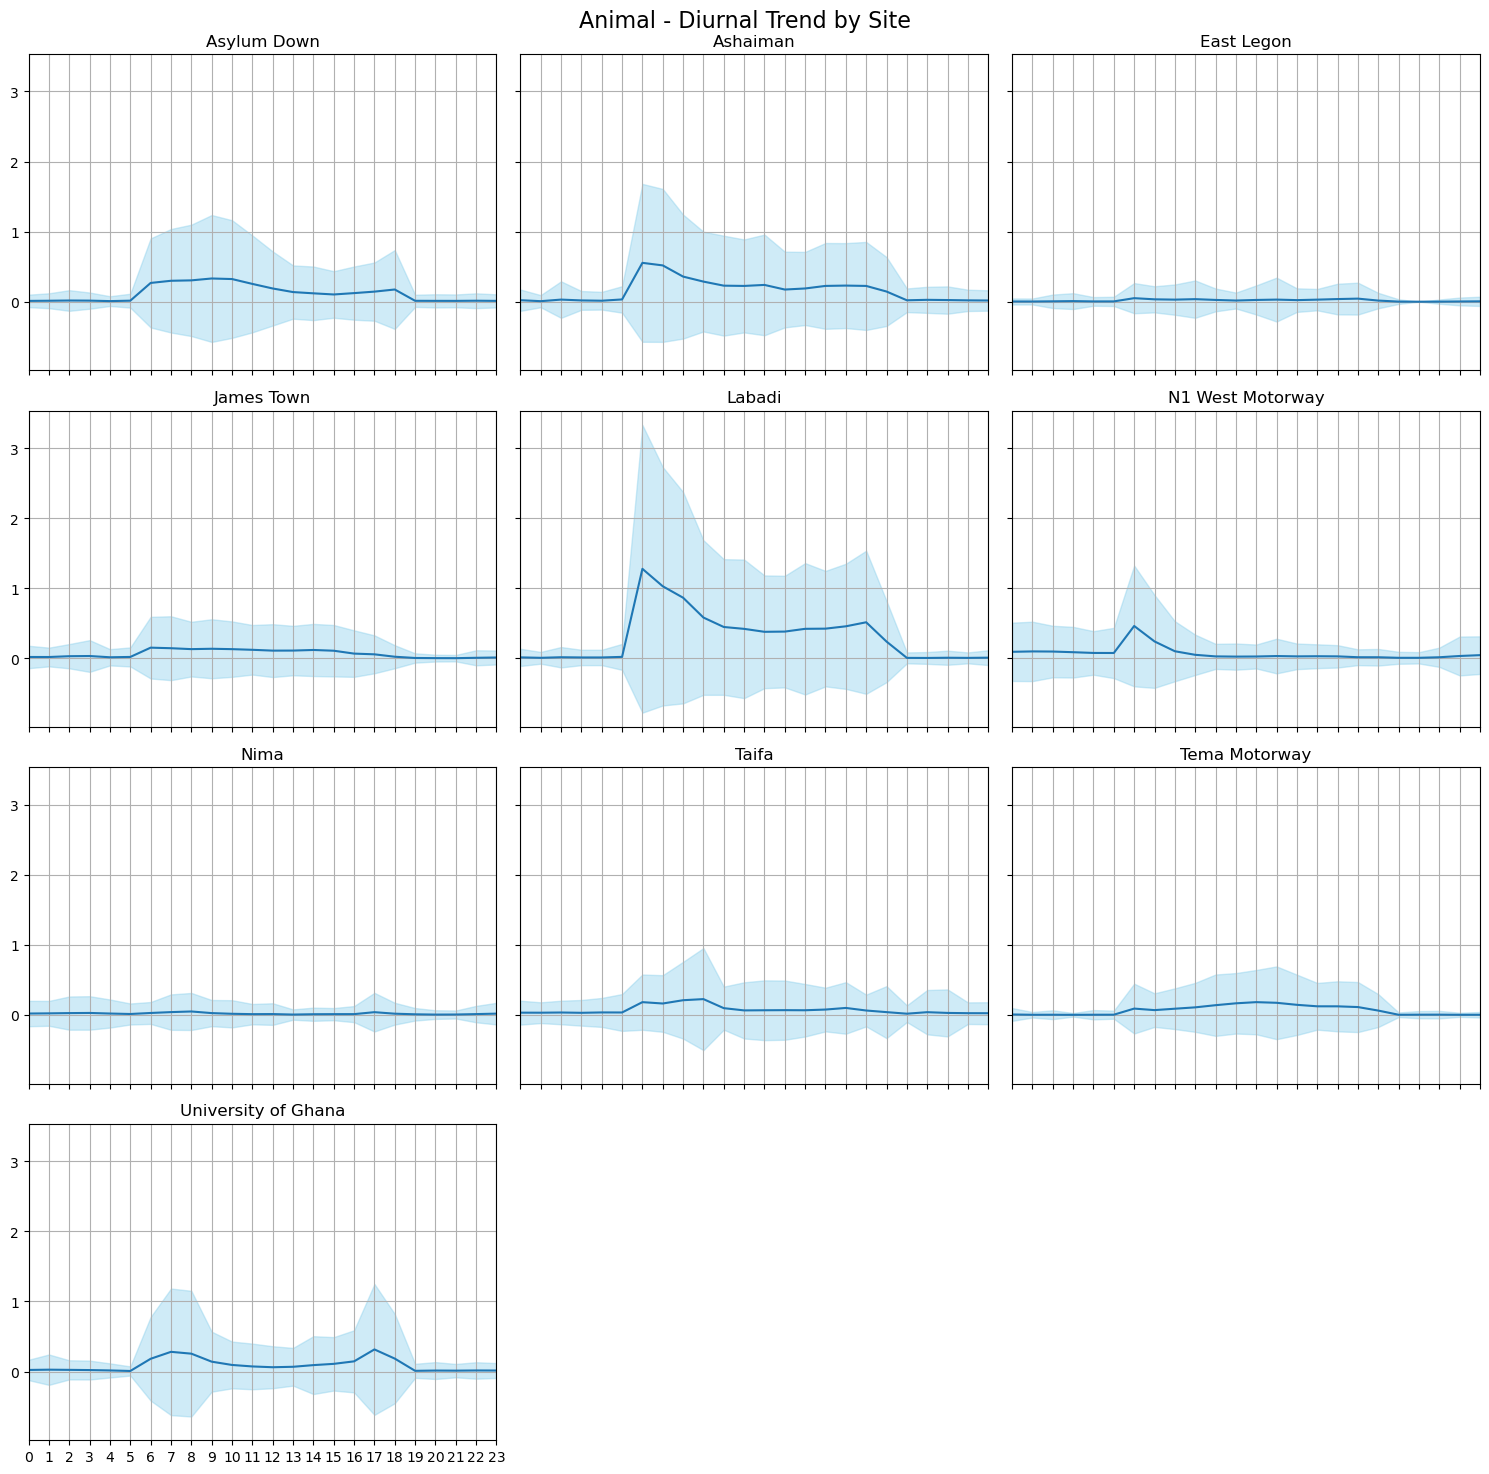

In [68]:
# Extend super_categories to include 'animal' as its own category
super_categories['animal'] = ['animal']

# Define the grid layout for the subplots
nrows, ncols = 4, 3

# Create the plots for each super-category
for super_cat, categories in super_categories.items():
    # Append '_counts' to each category in the list for correct column reference
    count_columns = [cat + '_counts' for cat in categories]

    # Set up the plot for this super-category
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), sharex=True, sharey=True)
    fig.suptitle(super_cat.capitalize().replace("_"," ") + ' - Diurnal Trend by Site', fontsize=16)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Track the number of sites we have plotted
    sites_plotted = 0
    
    # Fill in each subplot
    for i, (site, site_details) in enumerate(site_type.items()):
        # Calculate the subplot index
        ax = axes[sites_plotted]
        sites_plotted += 1

        # Prepare the site data for plotting
        site_data = hourly_averages[hourly_averages['site_id'] == site]
        site_data = site_data.set_index('datetime')
        site_data = site_data[count_columns].sum(axis=1).groupby(site_data.index.hour).agg(['mean', 'std'])

        # Plotting
        ax.fill_between(site_data.index, 
                        site_data['mean'] - site_data['std'], 
                        site_data['mean'] + site_data['std'], 
                        color='skyblue', alpha=0.4)
        ax.plot(site_data.index, site_data['mean'], label='Mean count')
        ax.set_title(site_details[0])
        ax.set_xlim(left=0, right=23)  # Set x-axis to show hours 0 to 23
        ax.set_xticks(np.arange(0, 24, 1))
        ax.grid(True)

    # Turn off any unused subplots
    for j in range(sites_plotted, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top spacing to accommodate suptitle
    plt.savefig('./results/'+super_cat+'.png')

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Define grid layout
nrows, ncols = 4, 3

# Create the plots for each super-category
for super_cat, categories in super_categories.items():
    # Correct column references
    count_columns = [cat + '_counts' for cat in categories]

    # Initialize the plot for this super-category
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    fig.suptitle(super_cat.capitalize().replace("_", " ") + ' - Diurnal Trend by Site', fontsize=16)

    # Flatten the axes array for easy access
    axes = axes.flatten()
    
    # Remove the subplot that will be empty (bottom left)
    fig.delaxes(axes[-3])
    axes[-3] = None  # Prevent accessing a deleted subplot

    # Plot data for each site
    for i, (site, site_details) in enumerate(site_type.items()):
        ax = axes[i] if i < 9 else fig.add_subplot(nrows, ncols, 11)
        
        # Prepare data for plotting
        site_data = hourly_averages[hourly_averages['site_id'] == site]
        site_data = site_data.set_index('datetime')
        hourly_data = site_data[count_columns].sum(axis=1).groupby(site_data.index.hour).agg(['mean', 'std'])
        
        # Fill and plot
        ax.fill_between(hourly_data.index,
                        hourly_data['mean'] - hourly_data['std'],
                        hourly_data['mean'] + hourly_data['std'],
                        color='skyblue', alpha=0.4)
        ax.plot(hourly_data.index, hourly_data['mean'], label='Mean count')
        ax.set_title(site_details[0])
        ax.set_xlim(0, 23)
        ax.set_ylim(bottom=0)

        # Draw horizontal grid lines for every hour
        ax.set_xticks(np.arange(0, 24, 1))
        ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.5)
        ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)
        
        # Thicker vertical lines for 6 and 18 hours
        ax.axvline(x=6, color='black', linestyle='-', linewidth=2)
        ax.axvline(x=18, color='black', linestyle='-', linewidth=2)

        # Manage x-ticks visibility
        if i not in [6, 8, 9]:  # i is the index in the flattened axes array
            ax.set_xticklabels([])  # Hide x-tick labels for non-specified subplots

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'./results/{super_cat}.png')
    plt.close(fig)
